Lets pretend I'm a HVAC repair company looking for clients to offer my services. I'd like to target my effort on customers that are most likely to use my services. I have access to aerial imagery of the roofs of houses in a city. I'd like to use this imagery to identify houses that have HVAC units on the roof that may be leaking. I have a set of 150 images labeled via spreadsheet in the following manner: 

'row_number' Images are numebred from 1 to 150  
'image_id' - a unique identifier for each image, ending ing in .jpeg, referencing a file  
'address' - The address of the house in the image  
'ac_present' - Whether or not an air conditioner is present on the roof of the house (Yes or No), followed by the number of air conditioners present in '()'  
'ac_leaking' - Whether or not the air conditioner is leaking (Yes, No or Unknown)  
'ac_discolored' - Whether or not the roof around any AC unit is discolored (Black, White, No, Unknown). Also may be both black and white, comma separated: "black, white" OR "white, black"  
'comments' - Any additional comments about the image from the labeler(s)  

In the images, the target house is bounded by an orange square.  

This will serve as my ground truth data. I'd like to build a model that can predict whether or not an air conditioner is leaking based on the aerial imagery of the roof of a house.

Step 1: Preprocessing the data : Load the data labels spreadsheet from the folder /data/labels/. The optional "number of air conditioners part in "()" should be split off and moved to a new column called num_ac, with all nulls set to 0.  Load in the images listed in image_id from the folder /data/images/ac_150_images/ in order to crop them around the orange bounding box. Output the images to a folder called 'ac_150_images_cropped'. The file names should be the 'image_id' from the spreadsheet, but with the .jpeg extension replaced with _cropped.jpeg. For example, an image with 'image_id' 56E8920C-C46B-4CC9-96CC-178AE00230D3.jpeg should be output as 56E8920C-C46B-4CC9-96CC-178AE00230D3_cropped.jpeg.



Step 2: Building the model : The model should be able to predict whether or not an air conditioner is leaking based on the aerial imagery of the roof of a house. Priority 1 is class prediction of whether or not an air conditioner is present. Priority 2 is class prediction of whether or not an air conditioner is leaking. Priority 3 is the color of discolored air conditioners. The model could be trained from scratch, fine-tuned from a pre-trained model, use a pre-trained model as a feature extractor, or just be a model off-the-shelf.  

Step 3: Model Evaluation : The model should be split into training, testing and validation sets. Hyperparameters may be tuned on the testing set. The model should be evaluated on the validation set. The model should account for class imbalance by weighting toward recall of minority classes.

The model should be evaluated using the following metrics:
- F1 Score (the loss function)
- Accuracy
- Precision
- Recall
- ROC AUC
- Confusion Matrix
- Classification Report
- Precision-Recall Curve
- ROC Curve
- Loss Curve

For this problem ...


**For this problem**, I'd recommend using a Convolutional Neural Network (CNN) to classify the images. CNNs are particularly well-suited for image classification tasks. You can use a pre-trained model as a feature extractor, or train a model from scratch. You can use any framework you like, but I'd recommend using **PyTorch**. You can use any additional libraries you like, but I'd recommend using scikit-learn for evaluation metrics.

**Given that we have 150 labeled images** and we are looking to classify the images into one of the following categories:
- Air Conditioner Present
- Air Conditioner Leaking
- **Color of Leaking when Leaking is Present**

This is a multi-class classification problem. We can use a CNN model to classify the images. 

We will be using a pre-trained model as a feature extractor. We will use the MobileNetV2 model, which is a small, low-latency model optimized for mobile devices. We will remove the top layer of the model, add a global average pooling layer, and add a dense layer with a softmax activation function to output the class probabilities.

We will use the following evaluation metrics:
- F1 Score (the loss function)
- Accuracy
- Precision
- Recall
- ROC AUC
- Confusion Matrix
- Classification Report
- Precision-Recall Curve
- ROC Curve
- Loss Curve

We will split the data into training, testing, and validation sets. We will tune hyperparameters on the testing set and evaluate the model on the validation set. We will account for class imbalance by weighting toward recall of minority classes.

Let's get started!


In [5]:
#**I need to install all the packages in this notebook**, so I will install them all at once
# Path: image_classification.ipynb
!pip install opencv-python
!pip install torch
!pip install torchvision
!pip install tqdm
!pip install seaborn
!pip install scikit-learn
!pip install pandas



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.5/10.5 MB 10.1 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 301.8/301.8 kB 9.6 MB/s eta 0:00:00


In [7]:
# Path: image_classification.ipynb
# Load the necessary libraries
import os
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve, f1_score
from sklearn.preprocessing import LabelBinarizer
from sklearn.utils.class_weight import compute_class_weight
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models import mobilenet_v2
from tqdm import tqdm
from PIL import Image
import seaborn as sns
import random


In [8]:
# Path: image_classification.ipynb
# Set the random seed for reproducibility
random_seed = 42
torch.manual_seed(random_seed)
np.random.seed(random_seed)
random.seed(random_seed)

In [9]:

## Step 1: Preprocessing the data
# Path: image_classification.ipynb
# Load the data labels spreadsheet
import re
data_labels_path = '../data/labels/ac_150_labels.csv'
data_labels = pd.read_csv(data_labels_path)

data_labels['num_ac'] = data_labels['ac_present'].str.extract(r"\(\s*(\d+)\s*\)").astype(float)



pd.set_option('future.no_silent_downcasting', True)
# Fill NaN values with 0
data_labels['num_ac'] = data_labels['num_ac'].fillna(0).infer_objects(copy=False)

def clean_string(s):
    # Replace all non-alphabetic characters with an empty string
    cleaned_string = re.sub(r'[^a-zA-Z]', '', s)
    # Convert the string to lowercase
    cleaned_string = cleaned_string.lower()
    return cleaned_string

# Apply the function to the the right columns column
for col in ['ac_present', 'ac_leaking', 'ac_discolored']:
    data_labels[col] = data_labels[col].astype(str)
    data_labels[col] = data_labels[col].apply(clean_string)

data_labels['black1hot'] = data_labels['ac_discolored'].str.contains('black').astype(int)

data_labels['white1hot'] = data_labels['ac_discolored'].str.contains('white').astype(int)

data_labels['present1hot'] = data_labels['ac_present'].str.contains('yes').astype(int)

data_labels['leaking1hot'] = data_labels['ac_leaking'].str.contains('yes').astype(int)

data_labels['present_unknown1hot'] = data_labels['ac_present'].str.contains('yes').astype(int)

data_labels['leaking_unknown1hot'] = data_labels['ac_leaking'].str.contains('yes').astype(int)

data_labels['color_unknown1hot'] = data_labels['ac_leaking'].str.contains('yes').astype(int)

data_labels['ac_present'] = data_labels['ac_present'].astype(str)
# Extract the numbers in brackets and convert them to integers
assert data_labels.loc[data_labels['ac_present'] == 'yes', 'num_ac'].min() == 1

data_labels.head()
# # Remove any leading or trailing spaces
# data_labels['ac_present'] = data_labels['ac_present'].str.strip()
# data_labels.loc[data_labels['ac_present'] == 'Yes','num_ac'].unique()

,row_number,image_id,address,ac_present,ac_leaking,ac_discolored,comments,num_ac,black1hot,white1hot,present1hot,leaking1hot,present_unknown1hot,leaking_unknown1hot,color_unknown1hot
0,1,347ED694-833B-4F44-ABD9-8A26E9BF12A7_1_201_a.jpeg,"1330 W Willow St, Lafayette, LA 70506, USA",yes,yes,blackwhite,NaN,4.0,1,1,1,1,1,1,1
1,2,56E8920C-C46B-4CC9-96CC-178AE00230D3.jpeg,"1110 N University Ave, Lafayette, LA 70506, USA",yes,unknown,unknown,"There is a black tone in all the roof parcel, ...",3.0,0,0,1,0,1,0,0
2,3,0AD2D165-CE95-4F5C-BF88-524EA08A686E.jpeg,"106 Madeline Ave, Lafayette, LA 70501, USA",no,no,no,NaN,0.0,0,0,0,0,0,0,0
3,4,66B175F8-4DAC-4FBA-B8F5-C26711B0C71F.jpeg,"200 S Bienville St, Lafayette, LA 70501, USA",yes,yes,black,NaN,2.0,1,0,1,1,1,1,1
4,5,55CE2555-D78E-49BE-8E89-476C586FEAE1.jpeg,"100 W St Louis St, Lafayette, LA 70506, USA",no,no,no,NaN,0.0,0,0,0,0,0,0,0


In [30]:





def crop_images_by_box(params):
    for image_id in params['image_ids']:  
        image_path = os.path.join(params['images_folder'], image_id)
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # Find the orange bounding box in the image
        hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        if params['hsv_range'] is not None:
            lower_orange = np.array(params['hsv_range'][0])
            upper_orange = np.array(params['hsv_range'][1])
            mask = cv2.inRange(hsv, lower_orange, upper_orange)
        else:
            mask = cv2.inRange(hsv, np.array([0,0,0]),np.array([180,255,255])) #no filter
    
        
        # Perform dilation on the mask to close small gaps
        if params['kernal'] is not None:
            kernel = params['kernal']
            mask = cv2.dilate(mask, kernel, iterations=2)
        
        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        # # Function to find the contour with the highest perimeter-to-area ratio
        # def find_hollow_box(contours):
        #     hollow_contour = None
        #     for contour in contours:
        #         area = cv2.contourArea(contour)
        #         perimeter = cv2.arcLength(contour, True)
        #         if area > params['min_area']:
        #             ratio = perimeter / area
        #             if ratio > params['min_ratio'] and perimeter > params['min_perimeter'] and perimeter < params['max_perimeter']:
        #                 hollow_contour = contour
        #                 print('ratio:' + str(ratio) + ' perimeter:' + str(perimeter) + ' area:' + str(area) + ' of image ' + image_id)
        #                 return hollow_contour   
        #     return None
        # # Find the contour that best matches a hollow box
        # contours = find_hollow_box(contours)
        if contours is None:
            print(f'No bounding box found for image {image_id}')
            continue
        else:
            # Find the largest rectangular contour
            largest_contour = max(contours, key=cv2.contourArea)
            
            # Get the bounding rectangle of the largest rectangular contour
            x, y, w, h = cv2.boundingRect(largest_contour)
            # Crop the image around the bounding rectangle
            cropped_image = image[y:y+h, x:x+w]
            
            # Save the cropped image
            cropped_image_path = os.path.join(params['cropped_images_folder'], image_id.replace('.jpeg', '_cropped.jpeg'))
            cv2.imwrite(cropped_image_path, cv2.cvtColor(cropped_image, cv2.COLOR_RGB2BGR))
            print(f'Image {image_id} cropped and saved to {cropped_image_path}')


    
    

In [114]:
def crop_images_by_box(params):
    for image_id in params['image_ids']:  
        image_path = os.path.join(params['images_folder'], image_id)
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # Find the orange bounding box in the image
        hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        if params['hsv_range'] is not None:
            lower_orange = np.array(params['hsv_range'][0])
            upper_orange = np.array(params['hsv_range'][1])
            mask = cv2.inRange(hsv, lower_orange, upper_orange)
        else:
            mask = cv2.inRange(hsv, np.array([0,0,0]),np.array([180,255,255])) #no filter
    
        
        # Perform dilation on the mask to close small gaps
        if params['kernal'] is not None:
            kernel = params['kernal']
            mask = cv2.dilate(mask, kernel, iterations=2)
        
        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        # Function to find the contour with the highest perimeter-to-area ratio
        def find_hollow_box(contours, mask, params):
            hollow_contours = []
            for contour in contours:
                # Get the bounding rectangle of the largest rectangular contour
                x, y, w, h = cv2.boundingRect(contour)
                # Crop the mask around the bounding rectangle
                cropped_mask = mask[y:y+h, x:x+w]
                mask_area = cv2.countNonZero(cropped_mask)
                bb_area = w*h
    
                if mask_area > 0:
                    ratio = bb_area / mask_area
                    if ratio > params['min_ratio'] and bb_area > params['min_bb_area'] and bb_area < params['max_bb_area']:
                        hollow_contours.append(contour)
                        #print('ratio:' + str(ratio) + ' bb_area:' + str(bb_area) + ' mask_area:' + str(mask_area) + ' of image ' + image_id)
                         
            return hollow_contours  
        # Find the contour that best matches a hollow box
        contours = find_hollow_box(contours, mask, params)
        if contours == []:
            print(f'No bounding box found for image {image_id}')
            continue
        else:
            # Find the largest rectangular contour
            largest_contour = max(contours, key=cv2.contourArea)
            
            # Get the bounding rectangle of the largest rectangular contour
            x, y, w, h = cv2.boundingRect(largest_contour)
            # Crop the image around the bounding rectangle
            cropped_image = image[y:y+h, x:x+w]
    
            # Save the cropped image
            cropped_image_path = os.path.join(params['cropped_images_folder'], image_id.replace('.jpeg', '_cropped.jpeg'))
            cv2.imwrite(cropped_image_path, cv2.cvtColor(cropped_image, cv2.COLOR_RGB2BGR))
            
            #print(f'Image {image_id} cropped and saved to {cropped_image_path}')
    return image,cropped_image,mask

'347ED694-833B-4F44-ABD9-8A26E9BF12A7_1_201_a.jpeg'

In [218]:

# Load the images and crop them around the orange bounding box
# Path: image_classification.ipynb
images_folder = '../data/images/ac_150_images/'
cropped_images_folder = '../data/images/ac_150_images_cropped/'
os.makedirs(cropped_images_folder, exist_ok=True)

params = {}
params['image_ids'] = data_labels['image_id']
#params['image_ids'] = np.array(['347ED694-833B-4F44-ABD9-8A26E9BF12A7_1_201_a.jpeg'])
params['images_folder'] = images_folder
params['cropped_images_folder'] = cropped_images_folder
params['hsv_range'] = [[8, 120, 200], [12, 255, 255]] #filter for a specific color (tested for 100% capture of 150 examples
params['kernal'] = np.ones((20,20), np.uint8)
params['min_bb_area'] = 1
params['max_bb_area'] = 1000000000
params['min_ratio'] = 1.0

image, cropped_image, mask = crop_images_by_box(params)

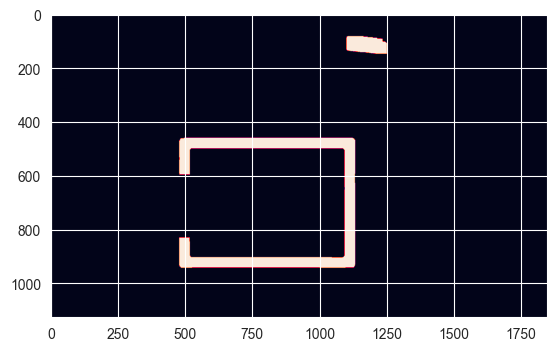

In [216]:
plt.imshow(mask)

In [219]:
    
## Step 2: Building the model
# Path: image_classification.ipynb
# Define the dataset class
class ACDataset(Dataset):
    def __init__(self, data_labels, images_folder, transform=None):
        self.data_labels = data_labels
        self.images_folder = images_folder
        self.transform = transform

    def __len__(self):
        return len(self.data_labels)

    def __getitem__(self, idx):
        image_id = self.data_labels.iloc[idx]['image_id']
        image_path = os.path.join(self.images_folder, image_id)
        image = Image.open(image_path)
        ac_present = self.data_labels.iloc[idx]['ac_present']
        ac_leaking = self.data_labels.iloc[idx]['ac_leaking']
        num_ac = self.data_labels.iloc[idx]['num_ac']
        ac_discolored = self.data_labels.iloc[idx]['ac_discolored']

        if self.transform:
            image = self.transform(image)

        return image, ac_present, ac_leaking, num_ac, ac_discolored

In [220]:
ACDataset(data_labels, images_folder, transform=None)

In [222]:
# Define the transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create the dataset
dataset = ACDataset(data_labels, cropped_images_folder, transform=transform)

In [223]:
# Split the dataset into training, testing, and validation sets

train_size = 0.8
test_size = 0.1
val_size = 0.1
num_samples = len(dataset)

indices = np.arange(num_samples)
train_indices, test_val_indices = train_test_split(indices, test_size=test_size+val_size, random_state=random_seed)
test_val_indices = np.array(test_val_indices)
test_indices, val_indices = train_test_split(test_val_indices, test_size=val_size/(test_size+val_size), random_state=random_seed)

train_dataset = torch.utils.data.Subset(dataset, train_indices)
test_dataset = torch.utils.data.Subset(dataset, test_indices)
val_dataset = torch.utils.data.Subset(dataset, val_indices)


In [225]:
# Define the dataloaders
batch_size = 16
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [235]:
# Load the pretrained MobileNetV2 model from torchvision
model_folder = '../data/models/'
model = mobilenet_v2()
checkpoint = torch.load(model_folder + 'mobilenet_v2-b0353104.pth')

# Load the weights from the checkpoint into the model
model.load_state_dict(checkpoint)


<All keys matched successfully>

In [236]:
# Retrain the model from the last layer
model.classifier[1] = nn.Linear(1280, 2)


In [237]:
# Define the loss function
criterion = nn.CrossEntropyLoss()
# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [238]:
# Train the model
num_epochs = 10
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for images, ac_present, ac_leaking, num_ac, ac_discolored in tqdm(train_dataloader):
        images = images.to(device)
        ac_present = ac_present.to(device)
        ac_leaking = ac_leaking.to(device)
        num_ac = num_ac.to(device)
        ac_discolored = ac_discolored.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, ac_present)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_losses.append(train_loss / len(train_dataloader))
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]}')

    model.eval()
    val_loss = 0.0
    for images, ac_present, ac_leaking, num_ac, ac_discolored in tqdm(val_dataloader):
        images = images.to(device)
        ac_present = ac_present.to(device)
        ac_leaking = ac_leaking.to(device)
        num_ac = num_ac.to(device)
        ac_discolored = ac_discolored.to(device)

        outputs = model(images)
        loss = criterion(outputs, ac_present)
        val_loss += loss.item()

    val_losses.append(val_loss / len(val_dataloader))
    print(f'Epoch {epoch+1}/{num_epochs}, Validation Loss: {val_losses[-1]}')

  0%|          | 0/8 [00:00<?, ?it/s]


FileNotFoundError: [Errno 2] No such file or directory: '/Users/jkerlin/PycharmProjects/satana/data/images/ac_150_images_cropped/6898DE7F-74F6-42C7-80DC-6DA4D1319300.jpeg'

In [ ]:
# Evaluate the model
model.eval()
y_true = []
y_pred = []

for images, ac_present, ac_leaking, num_ac, ac_discolored in tqdm(test_dataloader):
    images = images.to(device)
    ac_present = ac_present.to(device)
    ac_leaking = ac_leaking.to(device)
    num_ac = num_ac.to(device)
    ac_discol

In [231]:
dir(model)

['T_destination',
 '__annotations__',
 '__call__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_apply',
 '_backward_hooks',
 '_backward_pre_hooks',
 '_buffers',
 '_call_impl',
 '_compiled_call_impl',
 '_forward_hooks',
 '_forward_hooks_always_called',
 '_forward_hooks_with_kwargs',
 '_forward_impl',
 '_forward_pre_hooks',
 '_forward_pre_hooks_with_kwargs',
 '_get_backward_hooks',
 '_get_backward_pre_hooks',
 '_get_name',
 '_is_full_backward_hook',
 '_load_from_state_dict',
 '_load_state_dict_post_hooks',
 '_load_state_dict_pre_hooks',
 '_maybe_warn_non_full_backward_hook',
 '_modules',
 '_named_members',
 '_non_per

In [ ]:
# Define the loss function
criterion = nn.CrossEntropyLoss()
# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# Train the model
num_epochs = 10
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for images, ac_present, ac_leaking, num_ac, ac_discolored in tqdm(train_dataloader):
        images = images.to(device)
        ac_present = ac_present.to(device)
        ac_leaking = ac_leaking.to(device)
        num_ac = num_ac.to(device)
        ac_discolored = ac_discolored.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, ac_present)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_losses.append(train_loss / len(train_dataloader))
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]}')

    model.eval()
    val_loss = 0.0
    for images, ac_present, ac_leaking, num_ac, ac_discolored in tqdm(val_dataloader):
        images = images.to(device)
        ac_present = ac_present.to(device)
        ac_leaking = ac_leaking.to(device)
        num_ac = num_ac.to(device)
        ac_discolored = ac_discolored.to(device)

        outputs = model(images)
        loss = criterion(outputs, ac_present)
        val_loss += loss.item()

    val_losses.append(val_loss / len(val_dataloader))
    print(f'Epoch {epoch+1}/{num_epochs}, Validation Loss: {val_losses[-1]}')

In [ ]:
# Evaluate the model
model.eval()
y_true = []
y_pred = []

for images